<h1 align="center"><font color="yellow">LangChain 3a: Contando TOKENS em conversas para diferentes tipos de Memória conversacional</font></h1>

<font color="yellow">Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro</font>

# Contextualizando

<font color="orange">Neste script seguimos estudando o uso de Memória Conversacional. Mas agora vamos contar o Tokens usados em uma conversa para cada tipo de memória</font>

# Instalamos as bibliotecas necessárias e para a OpenAI API KEY

In [ ]:
#%pip install -qU langchain openai transformers

In [1]:
# Isto é quando usas o arquivo .env:
from dotenv import load_dotenv
import os
print('Carregando a minha chave Key: ', load_dotenv())
Eddy_API_KEY_OpenAI = os.environ['OPENAI_API_KEY'] 

Carregando a minha chave Key:  True


In [2]:
from getpass import getpass

import openai
from langchain import OpenAI
from langchain.chains import LLMChain, ConversationChain
from langchain.chains.conversation.memory import (
    ConversationBufferMemory,
    ConversationSummaryMemory,
    ConversationBufferWindowMemory,
    ConversationSummaryBufferMemory
)
from langchain.callbacks import get_openai_callback
from tqdm.auto import tqdm


<font color="orange">Usaremos o modelo `gpt-3.5-turbo` da OpenAI. Inicializamos via `LangChain` assim:</font>

In [4]:
llm = OpenAI(
    temperature=0, 
    openai_api_key=Eddy_API_KEY_OpenAI,
    model_name='gpt-3.5-turbo'  # Pode usar a LLM como 'text-davinci-003', também.
            )



<font color="orange">Para contar o número de TOKENS usados durante cada chamada, definiremos uma função `count_tokens`:</font>

In [5]:
def count_tokens(chain, query):
    with get_openai_callback() as cb:
        result = chain.run(query)
    return {
        'result': result,
        'token_count': cb.total_tokens
    }


<font color="orange">Vamos definir a função de conversação:</font>

In [6]:
queries = [
     "Bom dia IA?",
     """Meu interesse aqui é explorar o potencial da integração de Grandes
     Modelos de linguagem com conhecimento externo""",
     "Eu só quero analisar as diferentes possibilidades. O que você pode pensar?"
    #  "E quanto ao uso de aumento de recuperação, isso também pode ser usado?",
    #  """Isso é muito interessante, você pode me contar mais sobre isso?
    #  sistemas eu usaria para armazenar as informações e recuperar informações relevantes?""",
    #  """Tudo bem, tenho ouvido falar sobre 'bancos de dados vetoriais', eles são
    #  relevantes neste contexto?""",
    #  """Ok, isso é útil, mas como eu vou do meu conhecimento externo para
    #  criar esses 'vetores'? Não faço ideia de como um texto pode se tornar um vetor?""",
    #  """Bem, acho que não usaria word Embeddings, certo? Se eu quisesse
    #  armazenar meus documentos neste banco de dados vetorial, suponho que precisaria
    #  transformar os documentos em vetores? Talvez eu possa usar a 'sentence
    #  embeddings' para isso, o que você acha?""",
    #  """Sentence Embeddings podem representar apenas frases de texto? Isso parece
    #  meio pequeno para capturar qualquer significado de um documento? Existe alguma abordagem
    #  que pode codificar pelo menos um parágrafo de texto?""",
    #  """Huh, interessante. Lembro-me de ter lido algo sobre 'mpnet' ou
    #  Modelos de 'transformers' sentence 'minilm' que podem codificar de pequeno a
    #  parágrafos de tamanho médio. Estou errado sobre isso?""",
    #  """Ah, que bom ouvir isso, você sabe quanto texto eu posso alimentar
    #  nesses tipos de modelos?""",
    #  """Nunca ouvi falar de embeddings hierárquicos, você poderia explicar isso em
    #  Mais detalhes?""" 
          ]

In [7]:
def talk(conversation_chain):
    tokens_used = []
    # Percorremos a conversa acima, comntando o uso de Tokens à medida que avançamos:
    for user_query in tqdm(queries):
        try:
            res = count_tokens(conversation_chain, user_query)
            tokens_used.append(res['token_count'])
        except openai.error.InvalidRequestError:
            # Atingimos o Limite de token do Modelo, então quebre:
            break
    return tokens_used


<font color="orange">Criamos um conjunto de Chains de conversação que usaremos:</font>

In [10]:
conversation_chains = {
    'ConversationBufferMemory': ConversationChain(
        llm=llm, memory=ConversationBufferMemory()
    ),
    'ConversationSummaryMemory': ConversationChain(
        llm=llm, memory=ConversationSummaryMemory(llm=llm)
    ),
    'ConversationBufferWindowMemory(k=6)': ConversationChain(
        llm=llm, memory=ConversationBufferWindowMemory(k=1) # k=6
    ),
    'ConversationBufferWindowMemory(k=12)': ConversationChain(
        llm=llm, memory=ConversationBufferWindowMemory(k=1) # k=12
    ),
    'ConversationSummaryBufferMemory(k=6)': ConversationChain(
        llm=llm, memory=ConversationSummaryBufferMemory(
            llm=llm,
            max_token_limit= 3 # 650
        )
    ),
    'ConversationSummaryBufferMemory(k=12)': ConversationChain(
        llm=llm, memory=ConversationSummaryBufferMemory(
            llm=llm,
            max_token_limit= 5 # 1_300
        )
    )
}

In [ ]:
counts = {}
# Percorre cada um dos nossos tipos de memória acima:
for key, chain in conversation_chains.items():
    print(key)
    counts[key] = talk(chain)
    

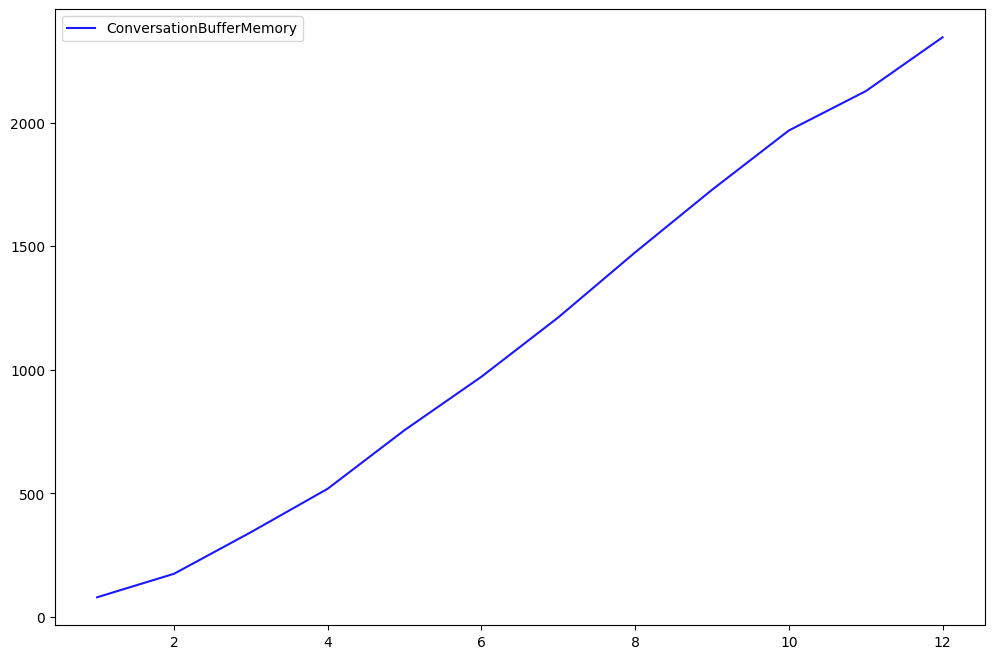

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
max_tokens = 4096

colors = ["#1c17ff", "#738FAB", "#f77f00", "#fcbf49", "#38c172", "#4dc0b5"]

for i, (key, count) in enumerate(counts.items()):
    color = colors[i]
    sns.lineplot(
        x=range(1, len(count)+1),
        y=count,
        label=key,
        color=color
    )
    if max_tokens in count:
        plt.plot(
            len(count), max_tokens, marker="X", color="red", markersize=10
        )

plt.show()

